Session 0.0: Load packages and customised functions

In [1]:
%reload_ext autoreload
%autoreload 2

In [15]:
## a useful function to generate a data list for further analysis
import os,json,sys,itertools
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from locustvr_converter import preprocess_matrex_data
from behavioural_classification import classify_heading_direction
##need to add this additional cell because useful tools are in another folder. Need to integrate these two folders one day
current_working_directory = Path.cwd()
parent_dir = current_working_directory.resolve().parents[0]
sys.path.insert(0, str(parent_dir) + "\\utilities")
from useful_tools import select_animals_gpt,find_file,read_seq_config
from data_cleaning import findLongestConseqSubseq,interp_fill

In [ ]:
import matplotlib as mpl
from matplotlib import cm
class MplColorHelper:
    def __init__(self, cmap_name, start_val, stop_val):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def get_rgb(self, val):
        return self.scalarMap.to_rgba(val)
colormap_name = "viridis"

Session 0.1: Load analysis methods in python dictionary form

In [3]:
json_file = "./analysis_methods_dictionary.json"
with open(json_file, "r") as f:
    analysis_methods = json.loads(f.read())
    

#Put the folder of your Unity experiment below
#thisDataset ="D:/MatrexVR_Swarm_Data/RunData"
#thisDataset ="D:/MatrexVR_blackbackground_Data/RunData"
#thisDataset ="D:/MatrexVR_grass1_Data/RunData"
#thisDataset ="D:/MatrexVR_navigation_Data/RunData"
thisDataset ="D:/MatrexVR_2024_Data/RunData"
#parameter name means independent variable in the experiment
#variable_name='kappa' 
variable_name='mu'
#variable_name='location'
#variable_name='initial_position'
#variable_name='agent_speed'

Session 0.2: Load animals' experiment directory into a list

In [4]:
## this cell searches for a folder with csv files, usually that is the folder saving the tracking data.
## Since data from the 4 VRs are saved in the same folder, this command will return that one folder for the 4 experiment
dir_list = []
file_type=".csv"
for root, dirs, files in os.walk(thisDataset):
    for folder in dirs:
        folder_path=os.path.join(root,folder)
        if any(name.endswith(file_type) for name in os.listdir(folder_path)):
            dir_list.append(folder_path.replace("\\", "/"))

print(f"these directories are found {dir_list}")

these directories are found ['D:/MatrexVR_2024_Data/RunData/20241110_123054', 'D:/MatrexVR_2024_Data/RunData/20241110_144142', 'D:/MatrexVR_2024_Data/RunData/20241110_165438', 'D:/MatrexVR_2024_Data/RunData/20241111_122609', 'D:/MatrexVR_2024_Data/RunData/20241111_143727', 'D:/MatrexVR_2024_Data/RunData/20241111_164808', 'D:/MatrexVR_2024_Data/RunData/20241112_123949', 'D:/MatrexVR_2024_Data/RunData/20241112_150308', 'D:/MatrexVR_2024_Data/RunData/20241112_171922', 'D:/MatrexVR_2024_Data/RunData/20241116_134457', 'D:/MatrexVR_2024_Data/RunData/20241116_155210', 'D:/MatrexVR_2024_Data/RunData/20241116_180011', 'D:/MatrexVR_2024_Data/RunData/20241117_130954', 'D:/MatrexVR_2024_Data/RunData/20241117_152042', 'D:/MatrexVR_2024_Data/RunData/20241117_173052', 'D:/MatrexVR_2024_Data/RunData/20241118_130021', 'D:/MatrexVR_2024_Data/RunData/20241118_151102', 'D:/MatrexVR_2024_Data/RunData/20241118_172046', 'D:/MatrexVR_2024_Data/RunData/20241124_132715', 'D:/MatrexVR_2024_Data/RunData/20241124_

In [6]:
dir_list=dir_list[92:-7]

In [ ]:
dir_list=dir_list[82:92]

### Session 0.3: pass temperature information into each folder

In [9]:
##This cell is used to move data of the thermo-humidity logger to animals'folder
import shutil
#tmp_file_name='matrexVR240824-240901.txt'
#tmp_file_name='DL220THP_Thermo2_241012_241014.csv'
tmp_file_name='DL220THP_Thermo3_250521_250523.csv'
tmp_source=os.path.join('Z:/Users/chiyu',tmp_file_name)
for this_dir in dir_list:
    tmp_new_dir = os.path.join(this_dir,tmp_file_name)
    if os.path.isfile(tmp_new_dir):
        print("Found EL USB temperature file in the new directory already")
    else:
        shutil.copy(tmp_source, tmp_new_dir)

In [7]:
analysis_methods

{'experiment_name': 'band',
 'overwrite_curated_dataset': True,
 'export_motion_only': False,
 'save_output': True,
 'time_series_analysis': True,
 'filtering_method': 'sg_filter',
 'plotting_trajectory': True,
 'plotting_event_distribution': True,
 'distribution_with_entire_body': True,
 'load_individual_data': True,
 'select_animals_by_condition': True,
 'active_trials_only': True,
 'split_stationary_moving_ISI': True,
 'align_with_isi_onset': False,
 'extract_follow_epoches': True,
 'follow_locustVR_criteria': False,
 'calculate_follow_chance_level': True,
 'analyse_first_half_only': False,
 'analyse_second_half_only': False,
 'graph_colour_code': ['r', 'b', 'g', 'k', 'c', 'y', 'm', 'r'],
 'follow_within_distance': 50,
 'camera_fps': 100,
 'trackball_radius_cm': 5,
 'monitor_fps': 60,
 'body_length': 4,
 'growth_condition': 'G',
 'analysis_window': [-10, 10]}

Session 1.0: Create curated dataset based on a list of experiment directories

In [ ]:
#This function receives directory path that contains the 4-VR data and save the tracking + stimulus information as h5 file
pattern="VR*.h5"
#pattern="VR*.parquet"
for this_dir in dir_list:
    if "archive" in this_dir:
        print(f"skip archive folder for {this_dir}")
        continue
    if any(Path(this_dir).glob(pattern)) and analysis_methods.get("overwrite_curated_dataset")==False:
        print(f"curated matrexvr h5 database found in {this_dir}. Skip this file")
        continue
    else:
        print(f"no curated matrexvr h5 database in {this_dir}. Create curated file")
        preprocess_matrex_data(this_dir,analysis_methods)

Session 2.0: select animal based on condition and return which a directory list and a list of vr rig number to specify which animal to analyse

In [4]:
# build up dir_list of animals based on condition.
dir_list = []
file_type=".h5"
using_google_sheet=True
sheet_name = "Unity_MatrexVR"
scene_name=analysis_methods.get("experiment_name")
if analysis_methods.get("load_individual_data") == True:
    if using_google_sheet==True:
        database_id = "1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8"
                #https://docs.google.com/spreadsheets/d/1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8/edit?usp=sharing
        url = f"https://docs.google.com/spreadsheets/d/{database_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
        #df = pd.read_excel(url, engine='openpyxl')## use this function if the file is not google sheet but uploaded excel file
        df = pd.read_csv(url)
    else:
        excel_file_path = "Z:/DATA/experiment_trackball_Optomotor/Locusts Management.xlsx"
        print(f"using a database {excel_file_path} from the server but this file might be outdated")
        # Create a 'with' statement to open and read the Excel file
        with pd.ExcelFile(excel_file_path) as xls:
            # Read the Excel sheet into a DataFrame with the sheet name (folder name)
            df = pd.read_excel(xls, sheet_name)
        ##list up the conditions and answers as strings for input argument to select animal. One condition must pair with one answer
    if analysis_methods.get("select_animals_by_condition") == True:
       #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)","gregarious_leader_grass","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
       #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)","gregarious_leader_black")
        #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)",variable_name,"Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable1",variable_name,"Independent variable2","bifuration_vr_locust_sta_black_locust","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        animal_of_interest=select_animals_gpt(df,"Independent variable1",variable_name,"Independent variable2","marching_band_black_vs_leader_locust_constant_speed&distance","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)",variable_name)
    else:
        animal_of_interest=df
    folder_name=animal_of_interest["folder name"].values
    dir_tile=np.tile(thisDataset, (len(folder_name), 1))
    vr_no=animal_of_interest["VR number"].values
    vr_no = vr_no.astype('int')
    no_food=animal_of_interest["Food retriction (-1 or the number of hours)"].values
    no_food = no_food.astype('int')
    dir_list = [''.join([x[0], '/', y]) for x,y in zip(dir_tile,folder_name)]
    dir_dict = zip(dir_list, vr_no.tolist())
else:
    for root, dirs, files in os.walk(thisDataset):
        for folder in dirs:
            folder_path=os.path.join(root,folder)
            if any(name.endswith(file_type) for name in os.listdir(folder_path)):
                dir_list.append(folder_path.replace("\\", "/"))

In [16]:
trial_evaluation_across_animals=[]
raster_across_animals_unity=[]
seq_config_all_animals=[]
animal_id=0
for this_dir,this_vr in zip(dir_list,vr_no):
    summary_pattern = f"VR{this_vr}*score_full.h5"
    xy_pattern = f"VR{this_vr}*XY_full.h5"
    found_result = find_file(Path(this_dir), summary_pattern)     
    trial_evaluation = pd.read_hdf(found_result)
    found_result = find_file(Path(this_dir), xy_pattern)        
    dfXY = pd.read_hdf(found_result)
    trial_evaluation.insert(0, 'VR',np.repeat(this_vr,trial_evaluation.shape[0]))
    trial_evaluation.insert(0, 'animal_id',np.repeat(animal_id,trial_evaluation.shape[0]))
    dfXY.insert(0, 'animal_id',np.repeat(animal_id,dfXY.shape[0]))
    seq_config_pattern=f"*sequenceConfig.json"
    seq_config_file=find_file(Path(this_dir), seq_config_pattern)
    seq_config_pd=read_seq_config(seq_config_file)
    seq_config_pd.insert(0, 'step_id',np.arange(seq_config_pd.shape[0]))
    seq_config_pd.insert(0, 'animal_id',np.repeat(animal_id,seq_config_pd.shape[0]))
    seq_config_all_animals.append(seq_config_pd)
    trial_evaluation_across_animals.append(trial_evaluation)
    raster_across_animals_unity.append(dfXY)
    animal_id +=1

In [25]:
if 'vr_no' in locals():
    df_all,dfxy_all=connect_two_tables(dir_list,analysis_methods,variable_name,vr_no)
else:
    df_all,dfxy_all=connect_two_tables(dir_dict,analysis_methods,variable_name)

i am using list


In [36]:
df_pd=pd.concat(df_all)
seq_config=pd.concat(seq_config_all_animals)

In [38]:
seq_config['VR']=df_pd['VR'].values

In [41]:
dfxy_pd=pd.concat(dfxy_all)

analyse bilateral_bandH0_constant_distance_black.json


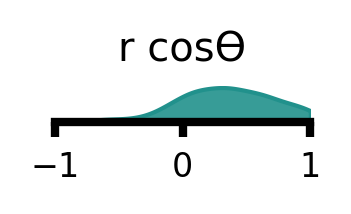

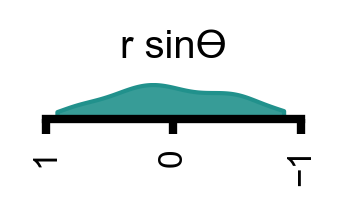

analyse bilateral_bandH0_constant_distance_black_x_gregarious.json


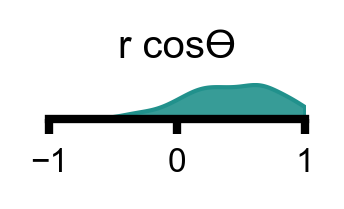

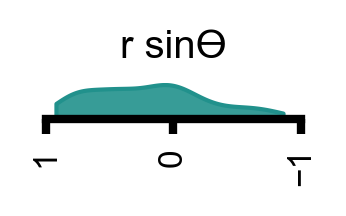

analyse bilateral_bandH0_constant_distance_gregarious.json


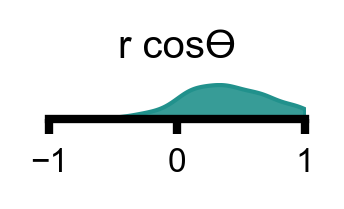

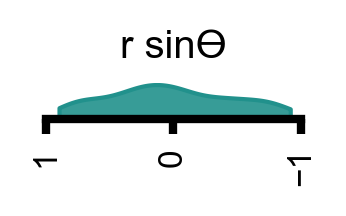

analyse bilateral_bandH0_constant_distance_gregarious_x_black.json


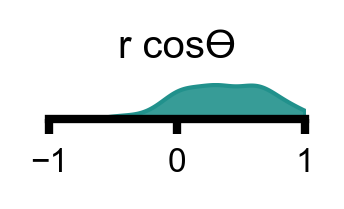

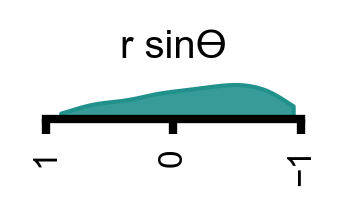

analyse bilateral_bandH60_constant_speed_black.json


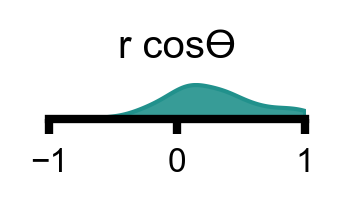

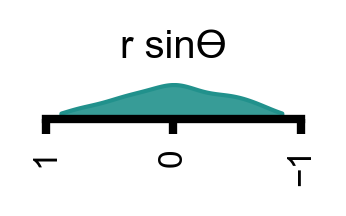

analyse bilateral_bandH60_constant_speed_black_x_gregarious.json


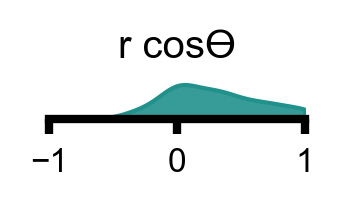

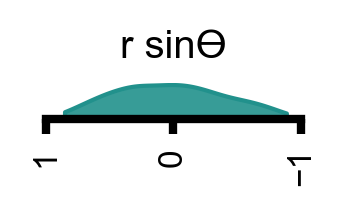

analyse bilateral_bandH60_constant_speed_gregarious.json


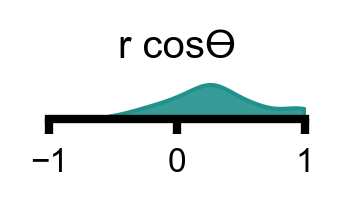

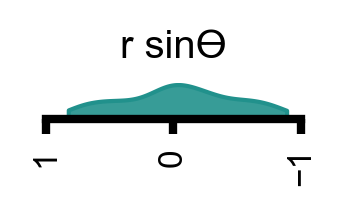

analyse bilateral_bandH60_constant_speed_gregarious_x_black.json


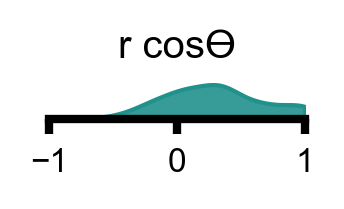

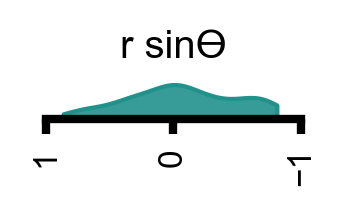

analyse bilateral_bandM_empty.json


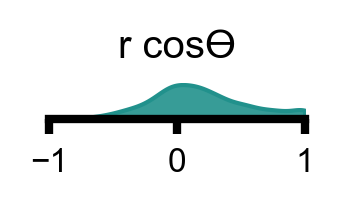

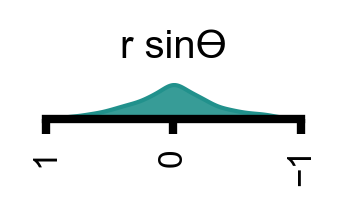

In [50]:
for key,grp  in seq_config.groupby('configFile'):
    print(f"analyse {key}")
    df_evaluation=df_pd.loc[df_pd['VR'].isin(grp['VR'])]
    plot_sercansincos(df_evaluation,analysis_methods,variable_name,'trial')

analyse bilateral_bandH0_constant_distance_black.json
263.6088045340714


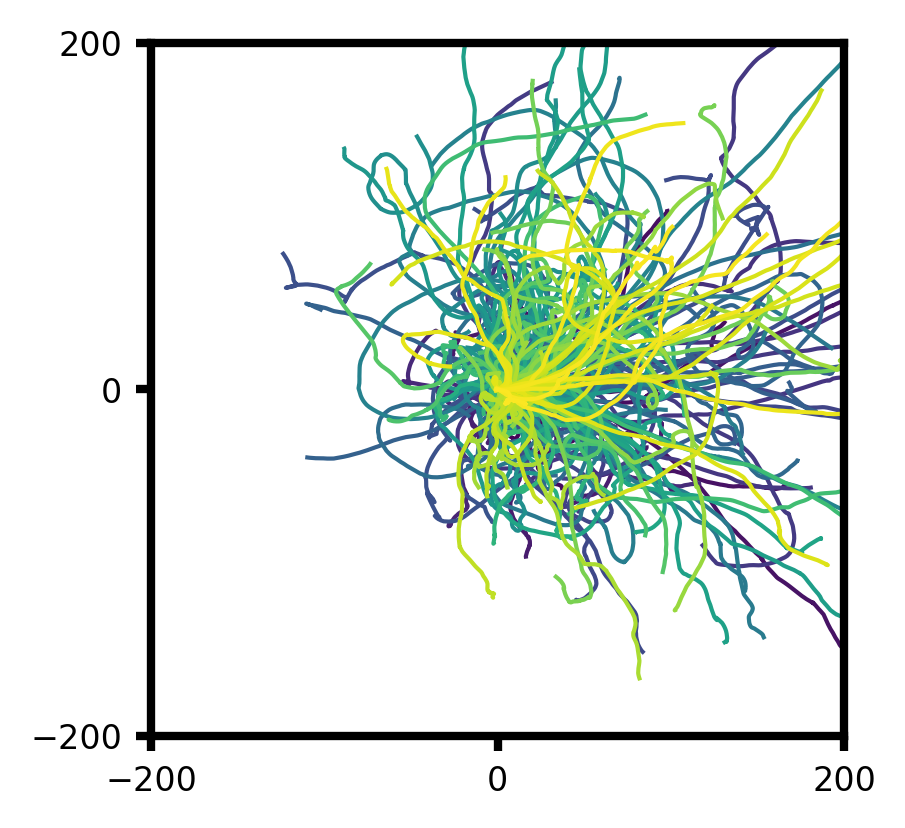

analyse bilateral_bandH0_constant_distance_black_x_gregarious.json
263.6088045340714


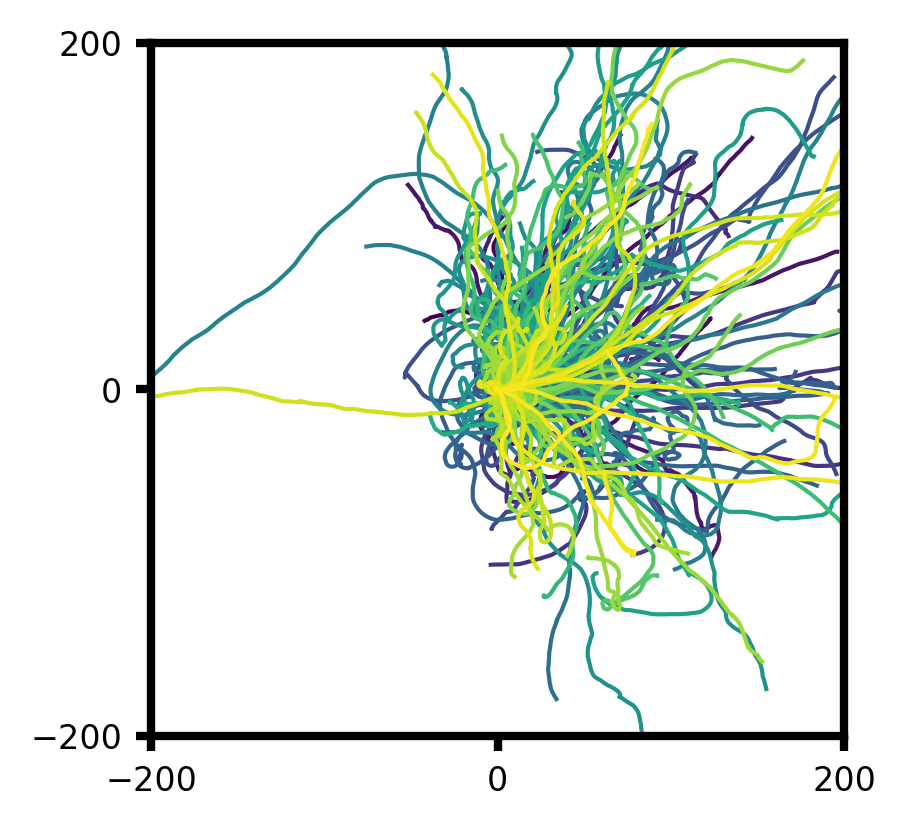

analyse bilateral_bandH0_constant_distance_gregarious.json
263.6088045340714


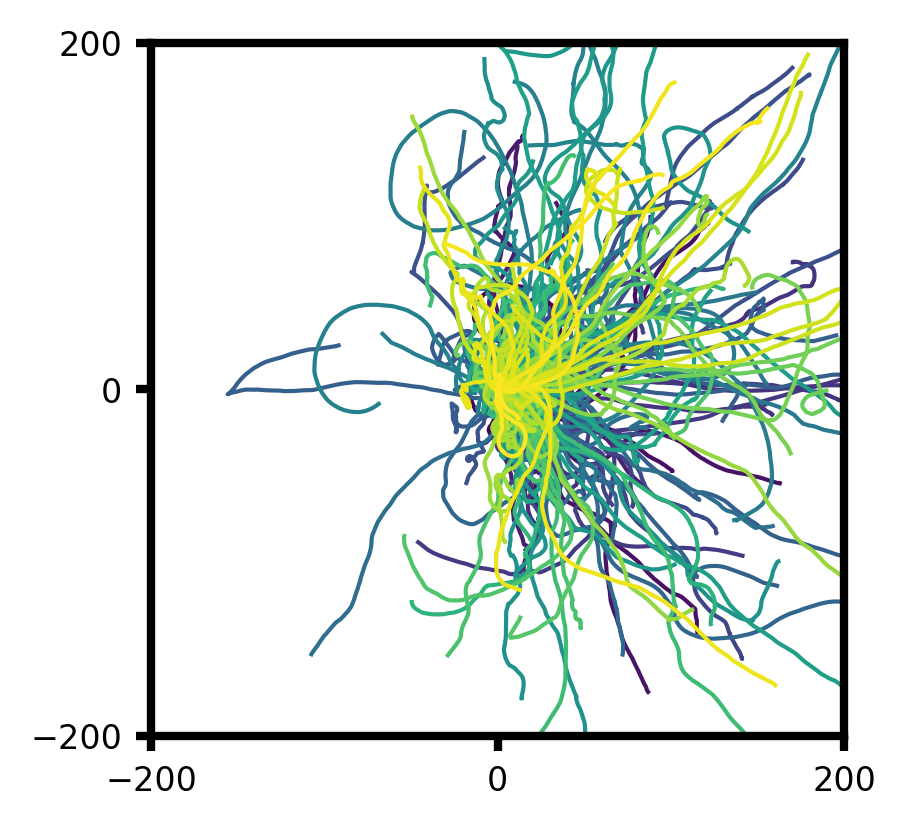

analyse bilateral_bandH0_constant_distance_gregarious_x_black.json
263.6088045340714


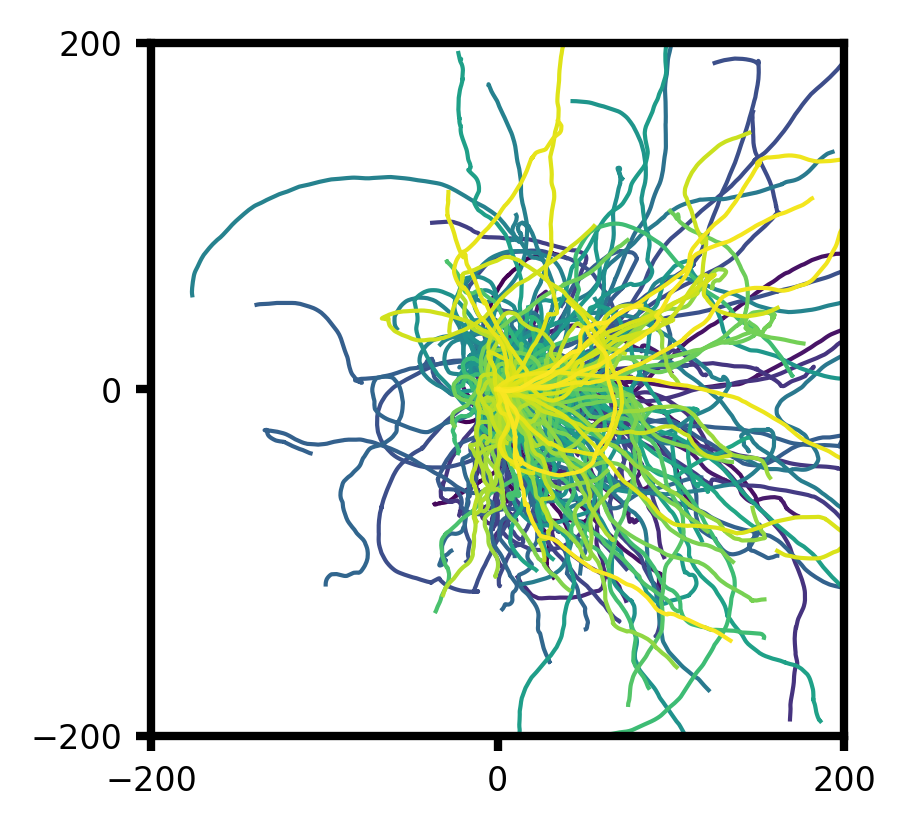

analyse bilateral_bandH60_constant_speed_black.json
2.6556232573509724


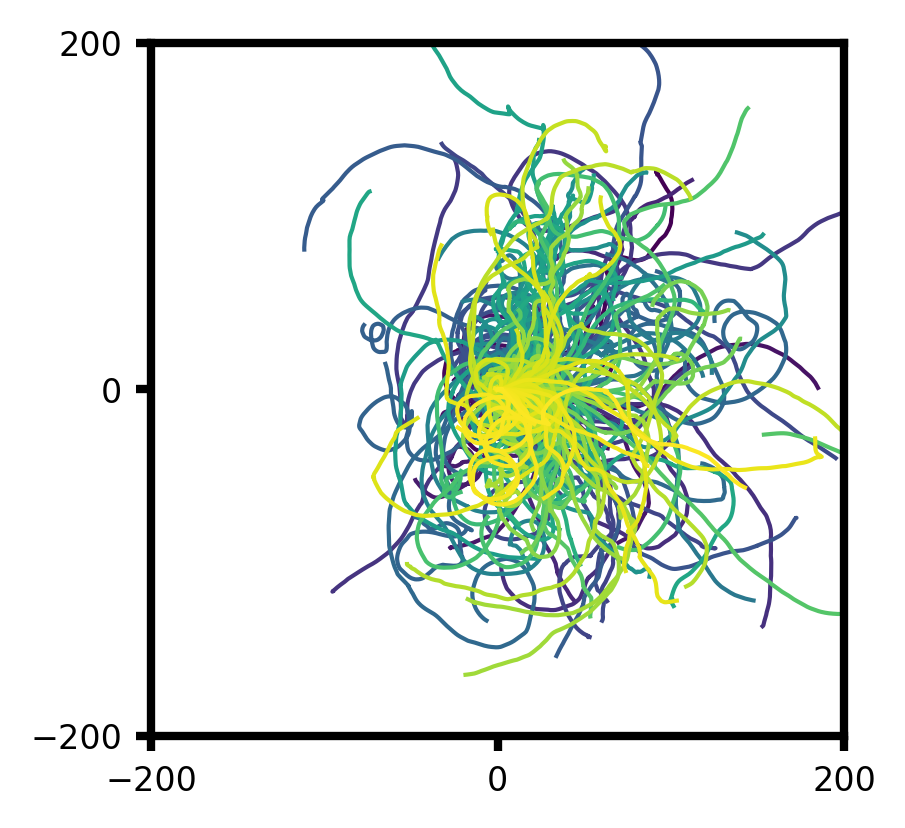

analyse bilateral_bandH60_constant_speed_black_x_gregarious.json
2.6556232573509724


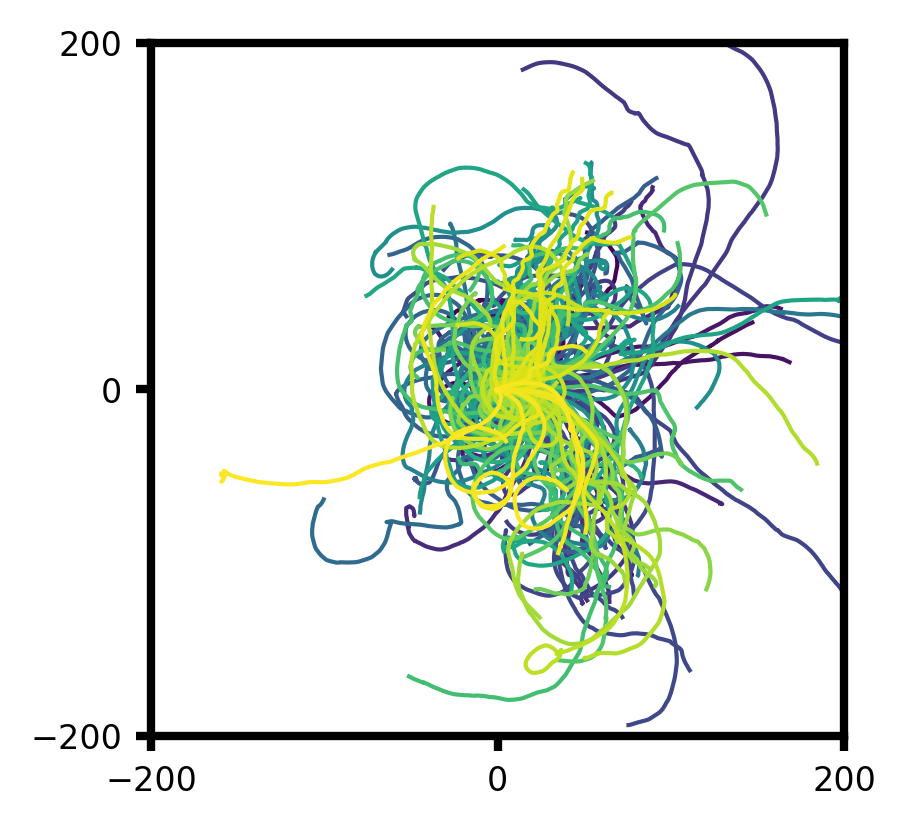

analyse bilateral_bandH60_constant_speed_gregarious.json
2.6556232573509724


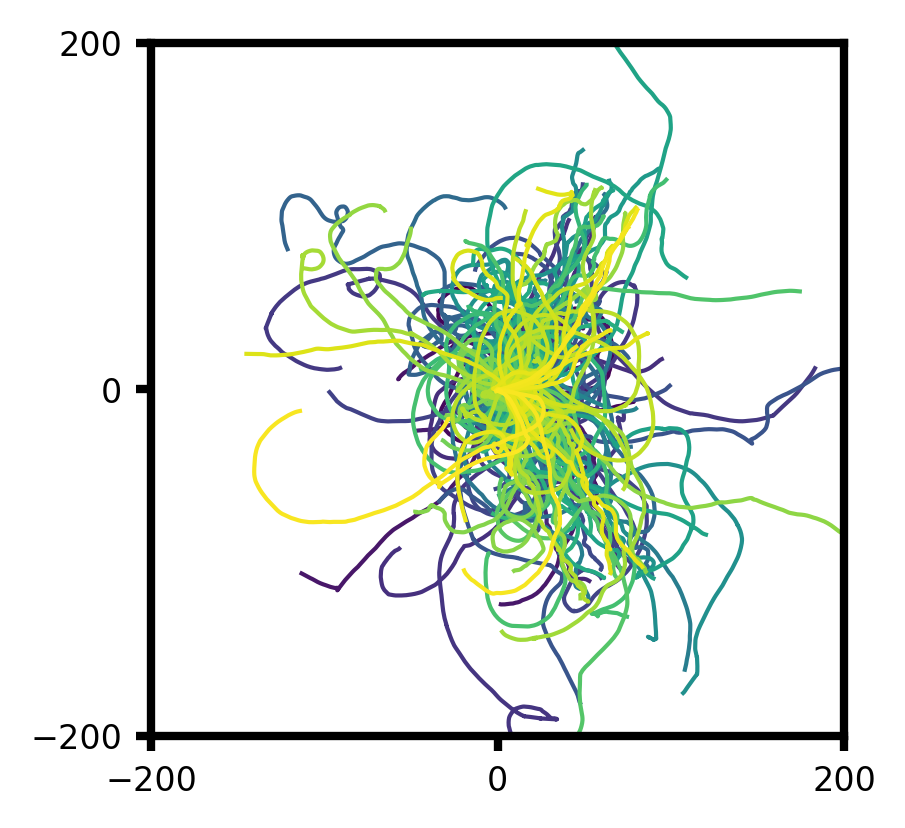

analyse bilateral_bandH60_constant_speed_gregarious_x_black.json
2.6556232573509724


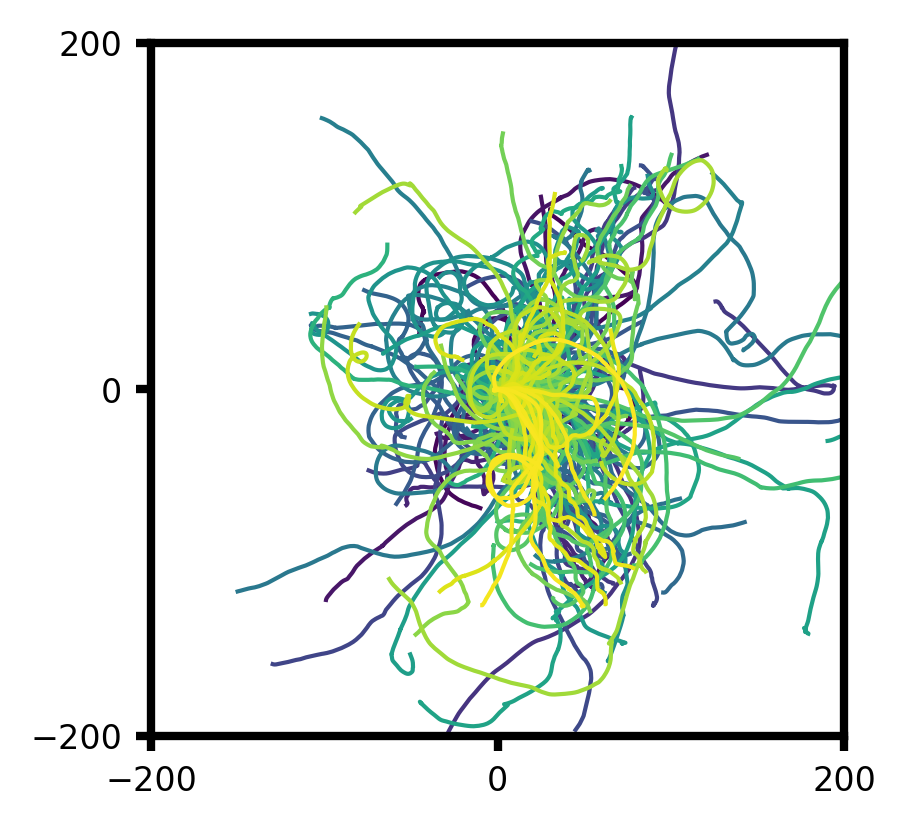

analyse bilateral_bandM_empty.json
0.0


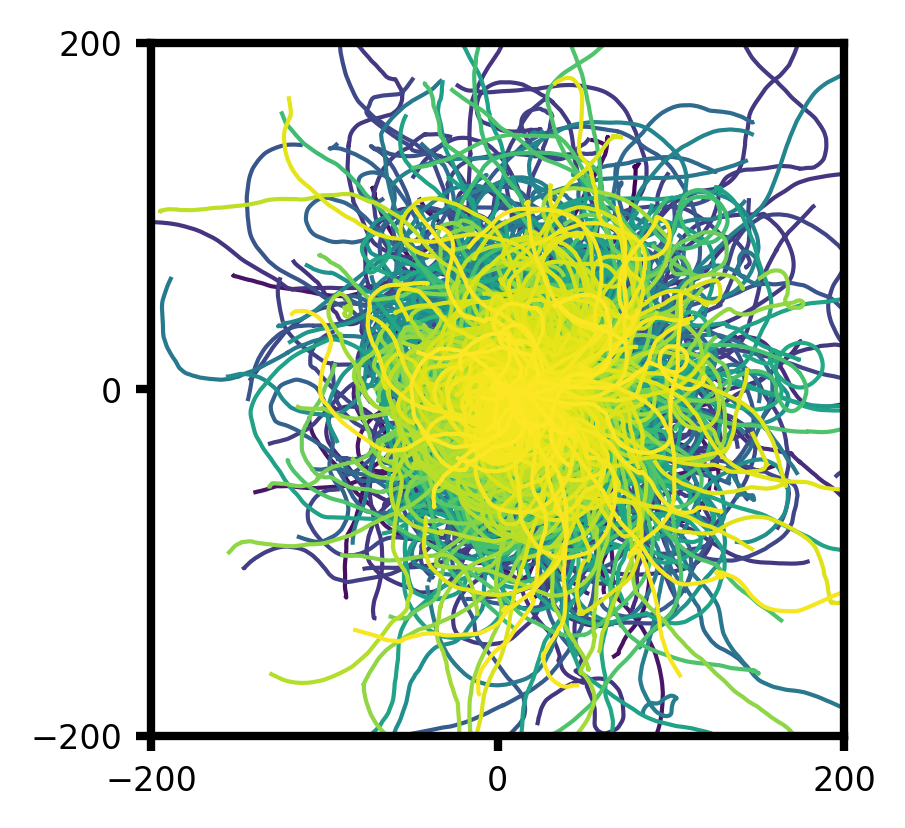

In [48]:
for key,grp  in seq_config.groupby('configFile'):
    print(f"analyse {key}")
    df_trials=dfxy_pd.loc[dfxy_pd['VR'].isin(grp['VR'])]
    plot_sercantrajec(df_trials,analysis_methods,key,'trial',trajec_lim=200,vr_num='all')

In [30]:
seq_config_all_animals[0]['VR']=df_all[0]['VR'].values[0]

In [32]:
seq_config_all_animals[0]

,animal_id,step_id,sceneName,Duration,configFile,VR
0,0,0,Choice,60,bilateral_bandM_empty.json,VR1_2025-05-21_105115
1,0,1,Choice,60,bilateral_bandH60_constant_speed_gregarious.json,VR1_2025-05-21_105115
2,0,2,Choice,60,bilateral_bandM_empty.json,VR1_2025-05-21_105115
3,0,3,Choice,60,bilateral_bandH60_constant_speed_black.json,VR1_2025-05-21_105115
4,0,4,Choice,60,bilateral_bandM_empty.json,VR1_2025-05-21_105115
...,...,...,...,...,...,...
107,0,107,Choice,60,bilateral_bandH0_constant_distance_black.json,VR1_2025-05-21_105115
108,0,108,Choice,60,bilateral_bandM_empty.json,VR1_2025-05-21_105115
109,0,109,Choice,60,bilateral_bandH0_constant_distance_gregarious....,VR1_2025-05-21_105115
110,0,110,Choice,60,bilateral_bandM_empty.json,VR1_2025-05-21_105115


In [ ]:
trial_evaluation

In [19]:
raster_across_animals_unity[0]

,animal_id,X,Y,heading,fname,mu,speed,duration,ts,temperature,humidity,density,kappa,radial_distance,polar_angle
0,0,-0.358338,-0.142574,NaN,2025-05-21_105115,0.0,4.0,60,0.000,27.49152,43.1212,0.000000,10000.0,32.0,NaN
1,0,-0.345852,-0.137588,NaN,2025-05-21_105115,0.0,4.0,60,0.011,27.49168,43.1208,0.000000,10000.0,32.0,NaN
2,0,-0.331646,-0.132012,NaN,2025-05-21_105115,0.0,4.0,60,0.011,27.49168,43.1208,0.000000,10000.0,32.0,NaN
3,0,-0.315773,-0.125855,NaN,2025-05-21_105115,0.0,4.0,60,0.011,27.49168,43.1208,0.000000,10000.0,32.0,NaN
4,0,-0.298285,-0.119125,NaN,2025-05-21_105115,0.0,4.0,60,0.011,27.49168,43.1208,0.000000,10000.0,32.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3594,0,5.560798,-64.479362,-1.495560,2025-05-21_124216,0.0,2.0,60,59.894,32.90000,32.0000,263.608805,10000.0,29.6,NaN
3595,0,5.560322,-64.533064,-1.489401,2025-05-21_124216,0.0,2.0,60,59.913,32.90000,32.0000,263.608805,10000.0,29.6,NaN
3596,0,5.559053,-64.589089,-1.489401,2025-05-21_124216,0.0,2.0,60,59.926,32.90000,32.0000,263.608805,10000.0,29.6,NaN
3597,0,5.556953,-64.647537,-1.474304,2025-05-21_124216,0.0,2.0,60,59.945,32.90000,32.0000,263.608805,10000.0,29.6,NaN


In [14]:
dfXY

,X,Y,heading,fname,mu,speed,duration,ts,temperature,humidity,density,kappa,radial_distance,polar_angle
0,-0.358338,-0.142574,NaN,2025-05-21_105115,0.0,4.0,60,0.000,27.49152,43.1212,0.000000,10000.0,32.0,NaN
1,-0.345852,-0.137588,NaN,2025-05-21_105115,0.0,4.0,60,0.011,27.49168,43.1208,0.000000,10000.0,32.0,NaN
2,-0.331646,-0.132012,NaN,2025-05-21_105115,0.0,4.0,60,0.011,27.49168,43.1208,0.000000,10000.0,32.0,NaN
3,-0.315773,-0.125855,NaN,2025-05-21_105115,0.0,4.0,60,0.011,27.49168,43.1208,0.000000,10000.0,32.0,NaN
4,-0.298285,-0.119125,NaN,2025-05-21_105115,0.0,4.0,60,0.011,27.49168,43.1208,0.000000,10000.0,32.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3594,5.560798,-64.479362,-1.495560,2025-05-21_124216,0.0,2.0,60,59.894,32.90000,32.0000,263.608805,10000.0,29.6,NaN
3595,5.560322,-64.533064,-1.489401,2025-05-21_124216,0.0,2.0,60,59.913,32.90000,32.0000,263.608805,10000.0,29.6,NaN
3596,5.559053,-64.589089,-1.489401,2025-05-21_124216,0.0,2.0,60,59.926,32.90000,32.0000,263.608805,10000.0,29.6,NaN
3597,5.556953,-64.647537,-1.474304,2025-05-21_124216,0.0,2.0,60,59.945,32.90000,32.0000,263.608805,10000.0,29.6,NaN


In [12]:
dfXY

,X,Y,heading,fname,mu,speed,duration,ts,temperature,humidity,density,kappa,radial_distance,polar_angle
0,-0.358338,-0.142574,NaN,2025-05-21_105115,0.0,4.0,60,0.000,27.49152,43.1212,0.000000,10000.0,32.0,NaN
1,-0.345852,-0.137588,NaN,2025-05-21_105115,0.0,4.0,60,0.011,27.49168,43.1208,0.000000,10000.0,32.0,NaN
2,-0.331646,-0.132012,NaN,2025-05-21_105115,0.0,4.0,60,0.011,27.49168,43.1208,0.000000,10000.0,32.0,NaN
3,-0.315773,-0.125855,NaN,2025-05-21_105115,0.0,4.0,60,0.011,27.49168,43.1208,0.000000,10000.0,32.0,NaN
4,-0.298285,-0.119125,NaN,2025-05-21_105115,0.0,4.0,60,0.011,27.49168,43.1208,0.000000,10000.0,32.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3594,5.560798,-64.479362,-1.495560,2025-05-21_124216,0.0,2.0,60,59.894,32.90000,32.0000,263.608805,10000.0,29.6,NaN
3595,5.560322,-64.533064,-1.489401,2025-05-21_124216,0.0,2.0,60,59.913,32.90000,32.0000,263.608805,10000.0,29.6,NaN
3596,5.559053,-64.589089,-1.489401,2025-05-21_124216,0.0,2.0,60,59.926,32.90000,32.0000,263.608805,10000.0,29.6,NaN
3597,5.556953,-64.647537,-1.474304,2025-05-21_124216,0.0,2.0,60,59.945,32.90000,32.0000,263.608805,10000.0,29.6,NaN


In [10]:
df

,fname,loss,mu,speed,groups,mean_angle,vector,variance,distX,distTotal,...,cos,duration,density,kappa,type,radial_distance,polar_angle,visibleOffDuration,visibleOnDuration,rotationAngle
0,2025-05-21_105115,0.0,0.0,4.0,G,-1.691945,0.176473,1.283376,-23.241294,163.111771,...,-0.021327,60,0.000000,10000.0,LocustBand,32.0,90.0,0.3,0.1,0
0,2025-05-21_105215,0.0,60.0,2.0,G,-0.169942,0.365248,1.126722,37.031536,144.068207,...,0.359987,60,2.655623,10000.0,LocustBand,29.6,60.0,0.0,0.1,60
0,2025-05-21_105315,0.0,0.0,4.0,G,0.857524,0.055619,1.374322,-7.434795,163.042344,...,0.036392,60,0.000000,10000.0,LocustBand,32.0,90.0,0.3,0.1,0
0,2025-05-21_105415,0.0,60.0,2.0,G,1.014160,0.757299,0.696707,92.460051,205.567154,...,0.400107,60,2.655623,10000.0,LocustBand_black,29.6,60.0,0.0,0.1,60
0,2025-05-21_105515,0.0,0.0,4.0,G,1.193808,0.445873,1.052736,18.617849,164.881583,...,0.164136,60,0.000000,10000.0,LocustBand,32.0,90.0,0.3,0.1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2025-05-21_123816,0.0,0.0,2.0,G,0.896408,0.919745,0.400638,16.820900,49.053834,...,0.574307,60,263.608805,10000.0,LocustBand_black,29.6,90.0,0.0,0.1,0
0,2025-05-21_123916,0.0,0.0,4.0,G,-0.185817,0.888687,0.471832,4.046600,18.255383,...,0.873389,60,0.000000,10000.0,LocustBand,32.0,90.0,0.3,0.1,0
0,2025-05-21_124016,0.0,0.0,2.0,G,-1.105156,0.706127,0.766646,24.518758,81.024773,...,0.317048,60,263.608805,10000.0,LocustBand,29.6,90.0,0.0,0.1,0
0,2025-05-21_124116,0.0,0.0,4.0,G,-2.534167,0.571609,0.925626,0.664898,33.611995,...,-0.469359,60,0.000000,10000.0,LocustBand,32.0,90.0,0.3,0.1,0


In [8]:
print(f"summary file found {found_result}")

summary file found None


Session 2.2: connecting information between two H5 files

Session 2.2.1: loading meta info from the json file (work in progress)

In [ ]:
#work in progress, this read condition directly from Control scene json file, which will be useful when not saving trial information into the simulated-agent file
'''
def read_condition_json(dir_list):
    j_pattern = f"*sequenceConfig.json"
    conditions_list=[]
    for this_dir in dir_list:
        found_result = find_file(Path(this_dir), j_pattern) 
        with open(found_result) as f:

            d = json.load(f)
            print(d["sequence"])

        for i in d["sequence"]:
            print("Mu:", i['Mu'])
            print("kappa:", i['kappa'])
            print("LocustSpeed:", i['LocustSpeed'])
            density = int(n_locusts.split(":")[1]) / (
            int(boundary_size.split(":")[1]) ** 2 / 10000
        )
            conditions = {
            "Density": density,
            mu.split(":")[0]: int(mu.split(":")[1]),
            "kappa": d["sequences"][0]['parameters']['kappa'],
            agent_speed.split(":")[0]: d["sequences"][0]['parameters']['LocustSpeed'],
        }
        conditions_list.append(conditions)
    return conditions_list
dir_list[0]
j_pattern = f"*sequenceConfig.json"
found_result = find_file(Path(this_dir), j_pattern)
test=pd.read_json(found_result)
print(test)
'''

Session 2.2.2: combine tables in the two lists in to 2 big tables

In [24]:
# When using spatial discretization, information about tracking quality is not logged in the dfXY, 
# hence there is a need to pass that information from df
def connect_two_tables(dir_list,analysis_methods,test_parameter='kappa',vr_no=[]):
    scene_name=analysis_methods.get("experiment_name")
    df_all=[]
    dfxy_all=[]
    dir_iterator=[]
    if len(vr_no)>0:
        print("i am using list")
        dir_iterator=zip(dir_list,vr_no)
    elif type(dir_list)==dict:
        print("i am using dictionary")
        dir_iterator=dir_dict
    else:
        print("there is a bug")
        return df_all,dfxy_all
    for this_dir,this_vr in dir_iterator:
        if Path(this_dir).is_dir()==False:
            continue
        summary_pattern = f"VR{this_vr}*score_full.h5"
        xy_pattern = f"VR{this_vr}*XY_full.h5"
        found_result = find_file(Path(this_dir), summary_pattern)        
        df = pd.read_hdf(found_result)
        df['VR'] = np.tile(f"VR{this_vr}", (len(df), 1))
        df['VR'] =df["VR"]+"_"+df["fname"]
        #COL = MplColorHelper(colormap_name, 0, num_independent_variable)
        found_result = find_file(Path(this_dir), xy_pattern)
        dfxy = pd.read_hdf(found_result)
        dfxy['VR'] = np.tile(f"VR{this_vr}", (len(dfxy), 1))
        dfxy['VR'] =dfxy["VR"]+"_"+dfxy["fname"]
        #df.loc[(df["distTotal"]<10.0) | (df["loss"]> 0.05), "distTotal"] = np.nan
        ##hardcode color code here for scatter plot
        if test_parameter == 'kappa':
            color_code={0.1: 0.2, 1.0: 0.4, 10.0: 0.6,100000.0:1}
        elif test_parameter == 'mu':
            if scene_name.lower()=='choice':
                #color_code={0: 0.1,45: 0.4,315: 0.7}
                color_code={0: 0.1,135: 0.4,225: 0.7}
            elif scene_name.lower()=='swarm':
                color_code={0: 0.1, 45: 0.2, 90: 0.3,135:0.4,180: 0.5, 225: 0.6, 270: 0.7,315:0.8}
            elif scene_name.lower()=='band':
                color_code={0: 0.1, 45: 0.2, 90: 0.3, 270: 0.7,315:0.8}
            else:
                return Warning('scene name not found')
        elif test_parameter == 'agent_speed':
            color_code={1.0: 0.2,2.0: 0.4, 4.0: 0.6,8.0:1}
        else:
            return Warning('test parameter not found')
        df['color_code'] = df[test_parameter].map(color_code)
        df_all.append(df)
        dfxy_all.append(dfxy)
    return df_all,dfxy_all

In [ ]:
if 'vr_no' in locals():
    df_all,dfxy_all=connect_two_tables(dir_list,analysis_methods,variable_name,vr_no)
else:
    df_all,dfxy_all=connect_two_tables(dir_dict,analysis_methods,variable_name)

Session 2.3: make summary plots of animals' response with customised plotting functions.

Session 2.3.1: introduce customised plotting functions used in Sercan's paper

In [45]:
#introduce customised functions
def plot_sercansincos(df,analysis_methods,parameters,variable_name,vr_num='all'):
    save_output= analysis_methods.get("save_output")
    scene_name=analysis_methods.get("experiment_name")
    if analysis_methods.get("active_trials_only"):
        active_trial='active_trials'
    else:
        active_trial=''
    
    cos = df["cos"]
    sin = df["sin"]
    if 'density' in df.columns:
        density=df["density"].unique()[0]
        cos_fig_name=f"{vr_num}_cos_{scene_name}_{variable_name}_{parameters}_density_{int(density)}{active_trial}.svg"
        sin_fig_name=f"{vr_num}_sin_{scene_name}_{variable_name}_{parameters}_density_{int(density)}{active_trial}.svg" 
    elif scene_name=='choice':
        cos_fig_name=f"{vr_num}_cos_{scene_name}_{variable_name}_{parameters}_single_target_{df['type'].values[0]}{active_trial}.svg"
        sin_fig_name=f"{vr_num}_sin_{scene_name}_{variable_name}_{parameters}_single_target_{df['type'].values[0]}{active_trial}.svg"

    fig, ax = plt.subplots(dpi=300, figsize=(1.1,0.25))
    #plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update({'font.size': 8})
    plt.rcParams['font.family'] = 'Arial'
    plt.set_cmap('cividis')
    # Set the axis line width to 2
    plt.rcParams['ytick.major.width'] = 2
    plt.rcParams['xtick.major.width'] = 2
    plt.rcParams['axes.linewidth'] = 2
    plt.subplots_adjust(bottom=0.4)
    sns.kdeplot(cos, cut=0, color="#21918c", fill=True, alpha=0.9)
    plt.xlim(-1,1)
    plt.title("r cos\u03F4")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
    plt.ylabel("")
    plt.xlabel("")    
    if save_output==True:
        plt.savefig(cos_fig_name)
    fig, ax = plt.subplots(dpi=300, figsize=(1.1,0.25))
    plt.subplots_adjust(bottom=0.4)
    sns.kdeplot(sin, cut=0, color="#21918c",  fill=True, alpha=0.9)#),lw=1,
    plt.xlim(1,-1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks(rotation = 90)
    ax.set_yticks([])
    plt.ylabel("")
    plt.xlabel("")
    plt.title("r sin\u03F4")
    if save_output==True:
        plt.savefig(sin_fig_name)
    plt.show()
def plot_sercantrajec(dfXY,analysis_methods,parameters,parameter_name,trajec_lim=1000,vr_num='all'):
    save_output= analysis_methods.get("save_output")
    scene_name=analysis_methods.get("experiment_name")
    if analysis_methods.get("active_trials_only"):
        active_trial='active_trials'
    else:
        active_trial=''
    
    a = dfXY.groupby('VR')
    if 'density' in dfXY.columns:
        density=dfXY["density"].unique()[0]
        print(density)
        fig_name=f"{vr_num}_summary_trajectory_{scene_name}_{parameter_name}_{parameters}_density_{int(density)}{active_trial}.png"
    else:
        fig_name=f"{vr_num}_summary_trajectory_{scene_name}_{parameter_name}_{parameters}_single_target_{dfXY['type'].values[0]}{active_trial}.png"

    fig, ax = plt.subplots(figsize=(3,3), dpi=300) 
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update({'font.size': 8})
    plt.rcParams['ytick.major.width'] = 2
    plt.rcParams['xtick.major.width'] = 2
    plt.rcParams['axes.linewidth'] = 2
    # Get the colormap
    cmap = plt.get_cmap('viridis')

    #plt.style.use('dark_background') 
    for i, (key2, grp2) in enumerate(a):
        color = cmap(i/ len(a))
        plt.plot(grp2["X"].values, grp2["Y"].values, color=color, linewidth=1)

    if type(parameters)==tuple:
        this_variable=parameters[0]
    else:
        this_variable=parameters


        # Here plot agent's trajectory with hardcode parameters
    if scene_name=='choice' and dfXY['type'].values[0] !='empty_trial':
        agent_speed=2
        radial_distance=8
        duration=60
        travel_direction=this_variable*-np.pi/180#the radian circle is clockwise in Unity, so 45 degree should be used as -45 degree in the regular radian circle
        radial_distance_b=np.cos(travel_direction)*radial_distance
        delta_cos=np.cumsum(np.repeat(np.cos(travel_direction)*agent_speed, duration))
        agent_cos=radial_distance_b+delta_cos
        radial_distance_b=np.sin(travel_direction)*radial_distance
        delta_sin=np.cumsum(np.repeat(np.sin(travel_direction)*agent_speed, duration))
        agent_sin=radial_distance_b+delta_sin
        plt.plot(agent_cos, agent_sin, color='k', linewidth=1)

    plt.xlim(-1*trajec_lim, trajec_lim)
    plt.ylim(-1*trajec_lim, trajec_lim)
    plt.yticks([-1*trajec_lim, 0, trajec_lim])
    plt.xticks([-1*trajec_lim, 0, trajec_lim])
        # Set the aspect ratio to be equal
    plt.gca().set_aspect('equal')                                                  
    if save_output==True:    
        plt.savefig(fig_name)
    plt.show()

Session 2.3.2: introduce a pilot scatter plot functions

In [ ]:
def plot_travel_distance_set(df_all,analysis_methods,variable_name,y_axis_lim=[0.1,1000]):
    colormap_name = "nipy_spectral"
    COL = MplColorHelper(colormap_name, 0, 10)
    
    fig, (ax1, ax2,ax3) = plt.subplots(
    nrows=1, ncols=3, figsize=(18, 6), tight_layout=True
)
    colour_code=analysis_methods.get("graph_colour_code")
    if variable_name=='kappa':
        ax1.set_xscale('log')
    #ax1.set_yscale('log')
    ax1.set_ylim([y_axis_lim[0],y_axis_lim[1]])
    ax1.set(
        yticks=[y_axis_lim[0], y_axis_lim[1]],
        ylabel="Travel distance per second",
        xticks=sorted(df_all[0][variable_name].unique()),
        xlabel=variable_name,
    )
    ax2.set(
        ylabel="trial n",
        xlabel="interval prior to trial n",
        xlim=[y_axis_lim[0],y_axis_lim[1]],
        ylim=[y_axis_lim[0],y_axis_lim[1]],
        title="travel distance per second",
    )
    ax3.set(
        ylabel="trial n",
        xlabel="trial n-1",
        xlim=[y_axis_lim[0],y_axis_lim[1]],
        ylim=[y_axis_lim[0],y_axis_lim[1]],
        title="travel distance per second",
    )
    #ax1.gca().set_aspect('equal')
    for id in np.arange(len(df_all)):
        df=df_all[id]
        viridis_code=df['color_code']*10#normalise the code from 1 to 10
        viridis_code=viridis_code.astype('int')
        #set some thresholds to remove bad tracking 
        #df.loc[(df["distTotal"]<50.0) | (df["loss"]> 0.05), "distTotal"] = np.nan
        if df.iloc[0]["VR"].startswith('VR1'):
            vr_color=colour_code[0]
        elif df.iloc[0]["VR"].startswith('VR2'):
            vr_color=colour_code[1]
        elif df.iloc[0]["VR"].startswith('VR3'):
            vr_color=colour_code[2]
        else:
            vr_color=colour_code[3]

        #ax1.scatter(df.iloc[::2][variable_name], df.iloc[::2]["distTotal"]/df.iloc[::2]["duration"],c='k')

        ax1.scatter(df.iloc[1::2][variable_name], df.iloc[1::2]["distTotal"]/df.iloc[1::2]["duration"],c=COL.get_rgb(viridis_code[1::2]))
        if df.shape[0] % 2 == 0:
            ax2.scatter(df.iloc[::2]["distTotal"]/df.iloc[::2]["duration"],df.iloc[1::2]["distTotal"]/df.iloc[1::2]["duration"],c=COL.get_rgb(viridis_code[1::2]))
        else:
            ax2.scatter(df.iloc[:-1:2]["distTotal"]/df.iloc[:-1:2]["duration"],df.iloc[1::2]["distTotal"]/df.iloc[1::2]["duration"],c=COL.get_rgb(viridis_code[1::2]))
        ax3.scatter(df.iloc[1:-2:2]["distTotal"]/df.iloc[1:-2:2]["duration"],df.iloc[3::2]["distTotal"]/df.iloc[3::2]["duration"],c=COL.get_rgb(viridis_code[3::2]))
    plt.show()

In [ ]:
#plot responses (mean angle and travel distance) from individual experiments (usually every 4 animal an experiment; different colour mark different animals in that experiment) 
#or comparing trial by trial response through normalised response (e.g. ratio to previous trial) or scatter plot (each dot means a comparison, 
#different colour means data from different rigs, different independent variables is marked with different kappa value)
## 1st: plots with independent variables such as kappa or mu against travel distance or angle
if len(df_all)>0:
    plot_travel_distance_set(df_all,analysis_methods,variable_name,y_axis_lim=[0,12])

Session 2.3.3: combine pandas dataframe across animals and filter out trials with bad tracking (these are preprocessing steps to use Sercan's functions)

In [ ]:
#Firstly, concatenate every animal's dataframe into a big table and then sort them based on conditions.
if len(dfxy_all)>0:
    dfxy_con = pd.concat(dfxy_all)
if len(df_all)>0:
    df_con = pd.concat(df_all)
good_tracking=df_con['loss']< 0.05
active_trials=(df_con['loss'] < 0.05) & (df_con["distTotal"]>50)

In [ ]:
analysis_methods.update({"save_output": True})

Session 2.3.4: plot trial by trial trajectory

In [ ]:
#plotting trajectory
#differentiate between stim and ISI based on columns in dfxy_con
if analysis_methods.get("active_trials_only"):
    df_interest=df_con[active_trials]
else:
    df_interest=df_con[good_tracking]


if analysis_methods.get("experiment_name")=="choice":
    stim_or_isi=dfxy_con['radial_distance']
elif analysis_methods.get("experiment_name")=="swarm" or analysis_methods.get("experiment_name")=="band":
    stim_or_isi=dfxy_con['density']
df_stim=dfxy_con.loc[(dfxy_con['VR'].isin(df_interest['VR'])) & (stim_or_isi>0)]
for key, grp in df_stim.groupby([variable_name,'type']):
    print(f"{variable_name}:{key}")
    plot_sercantrajec(grp,analysis_methods,key[0],variable_name,500)
df_isi=dfxy_con.loc[(dfxy_con['VR'].isin(df_interest["VR"])) & (stim_or_isi==0)]
for key, grp in df_isi.groupby([variable_name,'type']):
#for key, grp in df_isi.groupby(variable_name):
    print(f"{variable_name}:{key}")
    plot_sercantrajec(grp,analysis_methods,key[0],variable_name,500)
#xy_lim at around 2000 is good for trial lasts around 4 or 5 min
#xy_lim at around 500 is good for trial lasts around 1 min

Session 2.3.5: pool mean angle together to make KDE plots

In [ ]:
#Visualise the distribution of mean angle at sin and cos using seaborn kernel density estimation plot
#differentiate between stim and ISI based on columns in df_con
if analysis_methods.get("active_trials_only"):
    df_interest=df_con[active_trials]
else:
    df_interest=df_con

if analysis_methods.get("experiment_name")=="choice":
    stim_or_isi=df_interest['radial_distance']
elif analysis_methods.get("experiment_name")=="swarm" or analysis_methods.get("experiment_name")=="band":
    stim_or_isi=df_interest['density']
df_stim=df_interest[stim_or_isi>0]

for key, grp in df_stim.groupby([variable_name,'type']):
    print(f"{variable_name}:{key}")
    plot_sercansincos(grp,analysis_methods,key[0],variable_name)
df_isi=df_interest[stim_or_isi==0]
for key, grp in df_isi.groupby([variable_name,'type']):
    print(f"{variable_name}:{key}")
    plot_sercansincos(grp,analysis_methods,key[0],variable_name)

In [ ]:
def plot_circular_histrogram(df,analysis_methods,parameters,variable_name,vr_num='all'):
    save_output= analysis_methods.get("save_output")
    scene_name=analysis_methods.get("experiment_name")
    if analysis_methods.get("active_trials_only"):
        active_trial='active_trials'
    else:
        active_trial=''
    
    angles = df["mean_angle"]
    if 'density' in df.columns:
        density=df["density"].unique()[0]
        hist_fig_name=f"{vr_num}_circular_hist_{scene_name}_{variable_name}_{parameters}_density_{int(density)}{active_trial}.svg"
    elif scene_name=='choice':
        hist_fig_name=f"{vr_num}_circular_hist_{scene_name}_{variable_name}_{parameters}_single_target_{df['type'].values[0]}{active_trial}.svg"

    ax = plt.subplot(111, polar=True)
    ax.hist(angles, bins=24, alpha=0.75)
    #ax.set_xticks([])
    ax.set_yticks([5,10])
    ax.set_xticklabels([])
    #ax.set_title(f'banding direction: {parameters}')
    if save_output==True:
        plt.savefig(hist_fig_name)
    plt.show()
def plot_travel_histrogram(df,analysis_methods,parameters,variable_name,vr_num='all'):
    save_output= analysis_methods.get("save_output")
    scene_name=analysis_methods.get("experiment_name")
    if analysis_methods.get("active_trials_only"):
        active_trial='active_trials'
    else:
        active_trial=''
    distTotal = df["distTotal"]
    if 'density' in df.columns:
        density=df["density"].unique()[0]
        hist_fig_name=f"{vr_num}_travel_hist_{scene_name}_{variable_name}_{parameters}_density_{int(density)}{active_trial}.svg"
    elif scene_name=='choice':
        hist_fig_name=f"{vr_num}_travel_hist_{scene_name}_{variable_name}_{parameters}_single_target_{df['type'].values[0]}{active_trial}.svg"

    #fig, ax = plt.subplots(dpi=300, figsize=(1,1))
    fig, ax = plt.subplots(figsize=(5,2))
    ax.hist(distTotal, bins=24, alpha=0.75)
    ax.set_xticks([50,100])
    #ax.set_yticks([5,10])
    #ax.set_xticklabels([])
    #ax.set_title(f'banding direction: {parameters}')
    if save_output==True:
        plt.savefig(hist_fig_name)
    plt.show()

In [ ]:
#Visualise the distribution of  mean angle using seaborn kernel density estimation plot
#differentiate between stim and ISI based on columns in df_con
if analysis_methods.get("active_trials_only"):
    df_interest=df_con[active_trials]
else:
    df_interest=df_con
if analysis_methods.get("experiment_name")=="choice":
    stim_or_isi=df_interest['radial_distance']
elif analysis_methods.get("experiment_name")=="swarm" or analysis_methods.get("experiment_name")=="band":
    stim_or_isi=df_interest['density']
#df_stim=df_con[stim_or_isi>0]
df_stim=df_interest[stim_or_isi>0]
for key, grp in df_stim.groupby(parameter_name):
    print(f"{parameter_name}:{key}")
    plot_travel_histrogram(grp,analysis_methods,key,parameter_name)
    #plot_circular_histrogram(grp,analysis_methods,key,parameter_name)
#df_isi=df_con[stim_or_isi==0]
df_isi=df_interest[stim_or_isi==0]
for key, grp in df_isi.groupby(parameter_name):
    print(f"{parameter_name}:{key}")
    plot_travel_histrogram(grp,analysis_methods,key,parameter_name)
    #plot_circular_histrogram(grp,analysis_methods,key,parameter_name)

Session 2.3.5: plot individual animal's trajectory

In [ ]:
dir_iterator=[]
if len(vr_no)>0:
    print("i am using list")
    dir_iterator=zip(dir_list,vr_no)
elif type(dir_list)==dict:
    print("i am using dictionary")
    dir_iterator=dir_dict
else:
    print("there is a bug")
animal_count=0
for this_dir,this_vr in dir_iterator:
    if Path(this_dir).is_dir()==False:
        #print(f'no such a dir exist {this_dir}')
        continue
    locust_pattern = f"VR{this_vr}*XY.h5"
    found_result = find_file(Path(this_dir), locust_pattern)        
    print(found_result)
    #if str(found_result).endswith('VR2_2024-10-14_134515_XY.h5'):
    if str(found_result).endswith('VR4_2024-10-13_184515_XY.h5'):
        print('use this animal as example')
        dfxy = pd.read_hdf(found_result)
        dfxy['VR'] = np.tile(f"VR{this_vr}", (len(dfxy), 1))
        dfxy['VR'] =dfxy["VR"]+"_"+dfxy["fname"]
        summary_pattern = f"VR{this_vr}*score.h5"
        found_result = find_file(Path(this_dir), summary_pattern)        
        df = pd.read_hdf(found_result)
        df['VR'] = np.tile(f"VR{this_vr}", (len(df), 1))
        df['VR'] =df["VR"]+"_"+df["fname"]
        if analysis_methods.get("experiment_name")=="choice":
            stim_or_isi=dfxy['radial_distance']
        elif analysis_methods.get("experiment_name")=="swarm" or analysis_methods.get("experiment_name")=="band":
            stim_or_isi=dfxy['density']
        df_stim=dfxy.loc[(dfxy['VR'].isin(df['VR'])) & (stim_or_isi>0)]
        for key, grp in df_stim.groupby(parameter_name):
            print(f"kappa:{key},animal_id:{animal_count}")
            plot_sercantrajec(grp,analysis_methods,key,parameter_name,300)
        df_isi=dfxy.loc[(dfxy['VR'].isin(df['VR'])) & (stim_or_isi==0)]
        for key, grp in df_isi.groupby(parameter_name):
            print(f"kappa:{key}")
            plot_sercantrajec(grp,analysis_methods,key,parameter_name,300)
        animal_count=animal_count+1
    else:
        animal_count=animal_count+1
        continue

In [ ]:
#this is used to define active animals 
travel_distance_across_animals=np.ones(len(df_all))
for id in np.arange(len(df_all)):
    this_df=df_all[id]
    travel_distance_across_animals[id]=this_df[this_df['loss']< 0.05]['distTotal'].sum()
plt.hist(travel_distance_across_animals,bins=30)
plt.show()
## if an animal dont move at all, default analysis pipeline will out put 3 body length (12 cm) per trial, hence the minimum travel distance for an experiment is 12*(trial+ISI number)

In [ ]:
#note PI and OI during ISI does not make sense 
##next step, check animals' response across stim type, across trials
save_output= analysis_methods.get("save_output")
num_example_animal=22
all_OIs=np.ones((2,len(dfxy_all)))
all_PIs=np.ones((2,len(dfxy_all)))
all_PIs_follow_only=np.ones((2,len(dfxy_all)))
all_tortuosity=np.ones((4,len(dfxy_all)))## return NaN, if animals make one or less than one move; and if inactive animals are excluded from analysis
# if analysis_methods.get("experiment_name")=="choice":
#     stim_or_isi=dfxy_con['radial_distance']
# elif analysis_methods.get("experiment_name")=="swarm" or analysis_methods.get("experiment_name")=="band":
#     stim_or_isi=dfxy_con['density']
active_animal_threshold=2500
animal_count=0
for id in np.arange(len(dfxy_all)):
    if analysis_methods.get("active_animals_only",False):
        this_animal=df_all[id]
        if this_animal[this_animal['loss']< 0.05]['distTotal'].sum()>active_animal_threshold:
            pass
        else:
            all_OIs[:,animal_count]=np.nan
            all_PIs[:,animal_count]=np.nan
            all_tortuosity[:,animal_count]=np.nan
            animal_count=animal_count+1
            continue
    else:
        pass
    optomotor_stim=[]
    preference_stim=[]
    labels_stim=[]
    optomotor_isi=[]
    preference_isi=[]
    labels_isi=[]
    tortuosity_stim=[]
    tortuosity_isi=[]
    preference_stim_follow_of=[]
    preference_isi_follow_of=[]
    trial_id=0
    for key, grp in dfxy_all[id].groupby('fname'):
        if grp['density'][0]>0 or trial_id==0:## during trial or during pre-stim background, use default mu
            this_mu=grp['mu'].unique()[0]
        else:## during ISI, continue to use mu from previous trial to check how long navigation direction persist 
            pass
        this_hdf_file=dfxy_all[id].iloc[0]['VR']
        #generate labels of classification, index for that trials
        l,oi,pi,pi_follow_of_only=classify_heading_direction(grp['heading'].values,this_mu)
        #calculate tortuosity
        arc=np.sqrt(np.square(np.diff(grp['X'].values)) + np.square(np.diff(grp['Y'].values)))
        chord=np.sqrt(np.square(grp['X'].values[-1]-grp['X'].values[0])+np.square(grp['Y'].values[-1]-grp['Y'].values[0]))
        if chord>0:
            this_tortuosity=np.sum(arc)/chord
        else:
            this_tortuosity=np.nan
        if grp['density'][0]>0:
            optomotor_stim.append(oi)
            preference_stim.append(pi)
            preference_stim_follow_of.append(pi_follow_of_only)
            tortuosity_stim.append((np.sum(arc),chord))
            labels_stim.append(l)
            fig_title=f'{this_hdf_file}_trial{trial_id}_stim_{this_mu}'
        else:
            optomotor_isi.append(oi)
            preference_isi.append(pi)
            preference_isi_follow_of.append(pi_follow_of_only)
            tortuosity_isi.append((np.sum(arc),chord))
            labels_isi.append(l)
            fig_title=f'{this_hdf_file}_trial{trial_id}_isi_{this_mu}'
        if analysis_methods.get("plotting_trajectory",False) and animal_count==num_example_animal:
            print(dfxy_all[id].iloc[0]['VR'],this_mu)
            if grp['heading'].shape[0]>1:
                ax = plt.subplot(111, polar=True)
                ax.hist(grp['heading'].values, bins=24, alpha=0.75)
                fig2, ax2 = plt.subplots(
                nrows=1, ncols=1, figsize=(18, 6), tight_layout=True
            )
                xy=np.column_stack((grp["X"].values,grp["Y"].values))
                seg_no=1
                for start, stop in zip(xy[:-1], xy[1:]):
                    x, y = zip(start, stop)
                    if l[seg_no]=='for_of':
                        this_color='b'
                    elif l[seg_no]=="target_ob":
                        this_color='r'
                    elif l[seg_no]=="against_of":
                        this_color='c'
                    else:
                        this_color='k'
                    ax2.plot(x, y, color=this_color,linewidth=1)
                    ax2.set(xlim=(-250,250),ylim=(-250,250),aspect=('equal'))
                    seg_no=seg_no+1
                fig2.suptitle(fig_title)
                fig2_name=fig_title+'.png'
                if save_output:
                    fig2.savefig(fig2_name)
                plt.show()

        trial_id=trial_id+1

    if analysis_methods.get("plotting_trajectory",False) and animal_count==num_example_animal:
        decision_count = np.array([these_labels.size for these_labels in labels_stim])
        alpha_values=np.ones(decision_count.size)
        alpha_values[(decision_count < 10)] = 0.2
        alpha_values[(decision_count >= 10) & (decision_count < 20)] = 0.6
        alpha_values[(decision_count >= 20) & (decision_count < 30)] = 0.8
        alpha_values[(decision_count >= 30)] = 1
        fig1, axes = plt.subplots(
            nrows=4, ncols=3, figsize=(12, 9), tight_layout=True
        )
        ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12= axes.flatten()
        ax1.hist(optomotor_stim,color='k')
        ax1.hist(optomotor_isi,alpha = 0.05,color='k',ls='dashed',lw=3)
        ax2.hist(preference_stim_follow_of,color='k')
        ax2.hist(preference_isi_follow_of,alpha = 0.05,color='k',ls='dashed',lw=3)
        ax3.hist(preference_stim,color='k')
        ax3.hist(preference_isi,alpha = 0.05,color='k',ls='dashed',lw=3)
        ax4.scatter(np.array(optomotor_isi),np.array(optomotor_stim),color='k',alpha=alpha_values)
        ax5.scatter(np.array(preference_isi_follow_of),np.array(preference_stim_follow_of),color='k',alpha=alpha_values)
        ax6.scatter(np.array(preference_isi),np.array(preference_stim),color='k',alpha=alpha_values)
        ax7.scatter(np.array(optomotor_stim)[::2],np.array(optomotor_stim)[1::2],color='k',alpha=alpha_values[1::2])
        ax8.scatter(np.array(preference_stim_follow_of)[::2],np.array(preference_stim_follow_of)[1::2],color='k',alpha=alpha_values[1::2])
        ax9.scatter(np.array(preference_stim)[::2],np.array(preference_stim)[1::2],color='k',alpha=alpha_values[1::2])
        ax10.scatter(np.array(optomotor_stim)[1:-1:2],np.array(optomotor_stim)[3::2],color='k',alpha=alpha_values[1:-1:2])
        ax11.scatter(np.array(preference_stim_follow_of)[1:-1:2],np.array(preference_stim_follow_of)[3::2],color='k',alpha=alpha_values[1:-1:2])
        ax12.scatter(np.array(preference_stim)[1:-1:2],np.array(preference_stim)[3::2],color='k',alpha=alpha_values[1:-1:2])
        ax1.set(
        xlim=(-1.2,1.2),
        xlabel='optomotor index',
        ylabel='count of decision')
        ax2.set(
        xlim=(-1.2,1.2),
        xlabel='preference index (follow of vs. target ob)',
        ylabel='count of decision')
        ax3.set(
        xlim=(-1.2,1.2),
        xlabel='preference index',
        ylabel='count of decision')
        ax4.set(
        xlabel='optomotor index ISI',
        ylabel='optomotor index following Stim',
        xlim=(-1.2,1.2),
        ylim=(-1.2,1.2),
        yticks=([-1, 0, 1]),
        xticks=([-1, 0, 1]),
        aspect=('equal'))
        ax5.set(
        xlabel='preference index (follow of vs. target ob) ISI',
        ylabel='preference index (follow of vs. target ob) following Stim',
        xlim=(-1.2,1.2),
        ylim=(-1.2,1.2),
        yticks=([-1, 0, 1]),
        xticks=([-1, 0, 1]),
        aspect=('equal'))
        ax6.set(
        xlabel='preference index ISI',
        ylabel='preference index following Stim',
        xlim=(-1.2,1.2),
        ylim=(-1.2,1.2),
        yticks=([-1, 0, 1]),
        xticks=([-1, 0, 1]),
        aspect=('equal'))
        ax7.set(
        xlabel='optomotor index Stim n',
        ylabel='optomotor index Stim n+1',
        xlim=(-1.2,1.2),
        ylim=(-1.2,1.2),
        yticks=([-1, 0, 1]),
        xticks=([-1, 0, 1]),
        aspect=('equal'))
        ax8.set(
        xlabel='preference index (follow of vs. target ob) Stim n',
        ylabel='preference index (follow of vs. target ob) Stim n+1',
        xlim=(-1.2,1.2),
        ylim=(-1.2,1.2),
        yticks=([-1, 0, 1]),
        xticks=([-1, 0, 1]),
        aspect=('equal'))
        ax9.set(
        xlabel='preference index Stim n',
        ylabel='preference index Stim n+1',
        xlim=(-1.2,1.2),
        ylim=(-1.2,1.2),
        yticks=([-1, 0, 1]),
        xticks=([-1, 0, 1]),
        aspect=('equal'))
        ax10.set(
        xlabel='optomotor index Stim n',
        ylabel='optomotor index following ISI',
        xlim=(-1.2,1.2),
        ylim=(-1.2,1.2),
        yticks=([-1, 0, 1]),
        xticks=([-1, 0, 1]),
        aspect=('equal'))
        ax11.set(
        xlabel='preference index (follow of vs. target ob) Stim n',
        ylabel='preference index (follow of vs. target ob) following ISI',
        xlim=(-1.2,1.2),
        ylim=(-1.2,1.2),
        yticks=([-1, 0, 1]),
        xticks=([-1, 0, 1]),
        aspect=('equal'))
        ax12.set(
        xlabel='preference index Stim n',
        ylabel='preference index following ISI',
        xlim=(-1.2,1.2),
        ylim=(-1.2,1.2),
        yticks=([-1, 0, 1]),
        xticks=([-1, 0, 1]),
        aspect=('equal'))
        #fig1_title=f'animal_no{animal_count}'
        #fig1.suptitle(fig1_title)
        fig1_name=f'{this_hdf_file}_tbt_index_hist.svg'
        if save_output:
            fig1.savefig(fig1_name)
        plt.show()
    ## The OI and PI here are calculated based on responses pooled from every movement across trials
    labels_across_trials=np.concat(labels_stim)
    arc_chord_aba=np.concat(tortuosity_stim)
    all_tortuosity[0,animal_count]=np.nanmean(arc_chord_aba[::2]/arc_chord_aba[1::2])
    all_tortuosity[1,animal_count]=np.nanstd(arc_chord_aba[::2]/arc_chord_aba[1::2])/np.sqrt(np.count_nonzero(arc_chord_aba[1::2]!=0))
    of_responses=sum(labels_across_trials=="for_of")+sum(labels_across_trials=="against_of")
    all_OIs[0,animal_count]=(sum(labels_across_trials=="for_of")-sum(labels_across_trials=="against_of"))/of_responses
    all_PIs[0,animal_count]=(of_responses-sum(labels_across_trials=="target_ob"))/(of_responses+sum(labels_across_trials=="target_ob"))
    all_PIs_follow_only[0,animal_count]=(sum(labels_across_trials=="for_of")-sum(labels_across_trials=="target_ob"))/(sum(labels_across_trials=="for_of")+sum(labels_across_trials=="target_ob"))
    labels_across_trials=np.concat(labels_isi)
    arc_chord_aba=np.concat(tortuosity_isi)
    all_tortuosity[2,animal_count]=np.nanmean(arc_chord_aba[::2]/arc_chord_aba[1::2])
    all_tortuosity[3,animal_count]=np.nanstd(arc_chord_aba[::2]/arc_chord_aba[1::2])/np.sqrt(np.count_nonzero(arc_chord_aba[1::2]!=0))
    of_responses=sum(labels_across_trials=="for_of")+sum(labels_across_trials=="against_of")
    all_OIs[1,animal_count]=(sum(labels_across_trials=="for_of")-sum(labels_across_trials=="against_of"))/of_responses
    all_PIs[1,animal_count]=(of_responses-sum(labels_across_trials=="target_ob"))/(of_responses+sum(labels_across_trials=="target_ob"))
    all_PIs_follow_only[1,animal_count]=(sum(labels_across_trials=="for_of")-sum(labels_across_trials=="target_ob"))/(sum(labels_across_trials=="for_of")+sum(labels_across_trials=="target_ob"))
    animal_count=animal_count+1

In [ ]:
plot_pi_oi_comparison(all_PIs,all_OIs,all_tortuosity,all_PIs_follow_only,analysis_methods,travel_distance_across_animals)
plt.show()

In [ ]:
def plot_pi_oi_comparison(all_PIs,all_OIs,all_tortuosity,all_PIs_follow_only,analysis_methods,travel_distance=np.ones(all_OIs.shape[1]),parameters='',parameter_name='mu',vr_num='all'):
    save_output= analysis_methods.get("save_output")
    scene_name=analysis_methods.get("experiment_name")
    if analysis_methods.get("active_trials_only"):
        active_trial='active_trials'
    else:
        active_trial=''
    alpha_values=np.ones(all_OIs.shape[1])
    if np.sum(travel_distance)>travel_distance.shape[0]:
        alpha_values[(travel_distance < 2500)] = 0.2
        alpha_values[(travel_distance >= 5000) & (travel_distance < 15000)] = 0.6
        #travel_distance[(travel_distance >= 10000) & (travel_distance < 15000)] = 0.8
        alpha_values[(travel_distance >= 15000)] = 1
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 14))
    ax1,ax2,ax3,ax4,ax5,ax6= axes.flatten()
    ax1.scatter(all_PIs[1],all_tortuosity[2],c='g',alpha=alpha_values,label='ISIs')
    ax1.errorbar(all_PIs[1],all_tortuosity[2],yerr=all_tortuosity[3],c='g',fmt='o')
    ax1.scatter(all_PIs[0],all_tortuosity[0],c='k',alpha=alpha_values,label='Trials')##stim
    ax1.errorbar(all_PIs[0],all_tortuosity[0],yerr=all_tortuosity[1],c='k',fmt='o')
    ax2.scatter(all_OIs[1],all_tortuosity[2],c='g',label='ISIs')
    ax2.errorbar(all_OIs[1],all_tortuosity[2],yerr=all_tortuosity[3],c='g',fmt='o')
    ax2.scatter(all_OIs[0],all_tortuosity[0],c='k',label='Trials')##stim
    ax2.errorbar(all_OIs[0],all_tortuosity[0],yerr=all_tortuosity[1],c='k',fmt='o')
    ax3.scatter(all_OIs[1],all_PIs[1],c='g',alpha=alpha_values,label='ISIs')
    ax3.scatter(all_OIs[0],all_PIs[0],c='k',alpha=alpha_values,label='Trials')##stim
    ax4.scatter(all_PIs[0],all_PIs[1],c='b',alpha=alpha_values,label='preference index')
    ax4.scatter(all_OIs[0],all_OIs[1],c='r',alpha=alpha_values,label='optomotor index')
    ax5.scatter(all_OIs[1],all_PIs_follow_only[1],c='g',alpha=alpha_values,label='ISIs')
    ax5.scatter(all_OIs[0],all_PIs_follow_only[0],c='k',alpha=alpha_values,label='Trials')##stim
    ax6.scatter(all_PIs_follow_only[0],all_PIs_follow_only[1],c='b',alpha=alpha_values,label='(follow OF vs. Track OB)')
    ax6.scatter(all_OIs[0],all_OIs[1],c='r',alpha=alpha_values,label='optomotor index')
    ax1.set(
        xlim=(-1.2, 1.2),
        xticks=([-1, 0, 1]),
        xlabel='preference index',
        ylabel='tortuosity',
    )
    ax2.set(
        xlim=(-1.2, 1.2),
        xticks=([-1, 0, 1]),
        xlabel='optomotor index',
        ylabel='tortuosity',
    )
    ax3.set(
        xlim=(-1.2, 1.2),
        ylim=(-1.2, 1.2),
        yticks=([-1, 0, 1]),
        xticks=([-1, 0, 1]),
        xlabel='optomotor index',
        ylabel='preference index',
        aspect=('equal'),
    )
    ax4.set(
        xlim=(-1.2, 1.2),
        ylim=(-1.2, 1.2),
        yticks=([-1, 0, 1]),
        xticks=([-1, 0, 1]),
        aspect=('equal'),
        xlabel='index during trials',
        ylabel='index during ISIs',
    )
    ax5.set(
        xlim=(-1.2, 1.2),
        ylim=(-1.2, 1.2),
        yticks=([-1, 0, 1]),
        xticks=([-1, 0, 1]),
        xlabel='optomotor index',
        ylabel='preference index (follow OF vs. Track OB)',
        aspect=('equal'),
    )
    ax6.set(
        xlim=(-1.2, 1.2),
        ylim=(-1.2, 1.2),
        yticks=([-1, 0, 1]),
        xticks=([-1, 0, 1]),
        aspect=('equal'),
        xlabel='index during trials',
        ylabel='index during ISIs',
    )
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper left')
    ax3.legend(loc='upper left')
    ax4.legend(loc='upper left')
    ax5.legend(loc='upper left')
    ax6.legend(loc='upper left')
    fig.suptitle('+ pi means prefer optic flow, - means prefer target,; + oi means follow optic flow, - means go against optic flow')
    fig_name=f"{vr_num}_oi_pi_comparision_{scene_name}_{parameter_name}_{parameters}{active_trial}.svg"
    if save_output:
        fig.savefig(fig_name)

Session 2.3.6: plot individual animal's kernel density estimation plot

In [ ]:
dir_iterator=[]
if len(vr_no)>0:
    print("i am using list")
    dir_iterator=zip(dir_list,vr_no)
elif type(dir_list)==dict:
    print("i am using dictionary")
    dir_iterator=dir_dict
else:
    print("there is a bug")

for this_dir,this_vr in dir_iterator:
    if Path(this_dir).is_dir()==False:
        print(f'no such a dir exist {this_dir}')
        continue
    locust_pattern = f"VR{this_vr}*score.h5"
    found_result = find_file(Path(this_dir), locust_pattern)        
    df = pd.read_hdf(found_result)
    if analysis_methods.get("experiment_name")=="choice":
        stim_or_isi=df['radial_distance']
    elif analysis_methods.get("experiment_name")=="swarm" or analysis_methods.get("experiment_name")=="band":
        stim_or_isi=df['density']
    df_stim=df[stim_or_isi>0]
    for key, grp in df_stim.groupby(variable_name):
        print(f"{variable_name}:{key}")
        plot_sercansincos(grp,analysis_methods,key,parameter_name)
    df_isi=df[stim_or_isi==0]
    for key, grp in df_isi.groupby(parameter_name):
        print(f"{parameter_name}:{key}")
        plot_sercansincos(grp,analysis_methods,key,parameter_name)

[Optional] Analyse data with multi-engines

In [ ]:
##this cell start the multi-engines. Make sure to run only once
import time
import ipyparallel as ipp
def show_clusters():
    clusters = ipp.ClusterManager().load_clusters() 
    print("{:15} {:^10} {}".format("cluster_id", "state", "cluster_file")) 
    for c in clusters:
        cd = clusters[c].to_dict()
        cluster_id = cd['cluster']['cluster_id']
        controller_state = cd['controller']['state']['state']
        cluster_file = getattr(clusters[c], '_trait_values')['cluster_file']
        print("{:15} {:^10} {}".format(cluster_id, controller_state, cluster_file))
    return cluster_id

cluster = ipp.Cluster(n=6)
await cluster.start_cluster()
cluster_neuropc=show_clusters()

In [ ]:
##input cluster_id from previous cell
rc = ipp.Client(cluster_id=cluster_neuropc)

# Create a DirectView for parallel execution
dview = rc.direct_view()

# Define a function for parallel processing
def process_directory(this_dir, analysis_methods):
    from pathlib import Path
    import sys
    current_working_directory = Path.cwd()
    parent_dir = current_working_directory.resolve().parents[0]
    sys.path.insert(0, str(parent_dir) + "\\utilities")
    from locustvr_converter import preprocess_matrex_data
    preprocess_matrex_data(this_dir,analysis_methods)

# Define analysis_methods

# Use parallel execution to process directories
dview.map_sync(process_directory, dir_list, [analysis_methods] * len(dir_list))

In [ ]:
rc.shutdown()